In [1]:
from fastai.text import *
from pathlib import Path
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    text = d.get("reviewText","")
    rating = d.get("overall","")
    text_len = len(text.split(" "))
    category = path.name.strip(".json.gz")
    df[i] = text,rating,text_len,category
    i += 1
  return pd.DataFrame.from_dict(df, columns=["reviewText","overall","sentenceLength","category"], orient='index')

In [2]:
dataset_files = Path('../data/sample_top10/').glob("*.gz")
dataset_files

<generator object Path.glob at 0x7fe8278b6550>

In [3]:
frames = [getDF(f) for i,f in enumerate(dataset_files)] #if i < 4

In [4]:
type(frames[0]), len(frames)

(pandas.core.frame.DataFrame, 5)

In [5]:
result = pd.concat(frames)

In [6]:
result.shape

(12400238, 4)

In [7]:
result.head()

,reviewText,overall,sentenceLength,category
0,I purchased this cd for my Pocket Parrot. It h...,3.0,73,Pet_Supplies_5
1,"Maybe it's just my Amazon parrot, but she's no...",3.0,16,Pet_Supplies_5
2,I bought this to help me teach my blue quaker ...,5.0,51,Pet_Supplies_5
3,Bird showed no interest in it....,3.0,6,Pet_Supplies_5
4,Didn't do a thing for my African Grey! He hate...,2.0,16,Pet_Supplies_5


In [8]:
result.tail()

,reviewText,overall,sentenceLength,category
3410014,The singing parts are very good as expected fr...,4.0,38,Movies_and_TV_5
3410015,This recording of the 2015 production by the M...,5.0,117,Movies_and_TV_5
3410016,I do not wish to write a review about this rel...,4.0,409,Movies_and_TV_5
3410017,It was a gift.,5.0,4,Movies_and_TV_5
3410018,This Otello originates from the Salzburg Festi...,4.0,123,Movies_and_TV_5


In [9]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


Text(0.5, 1.0, '        Review counts by categories')

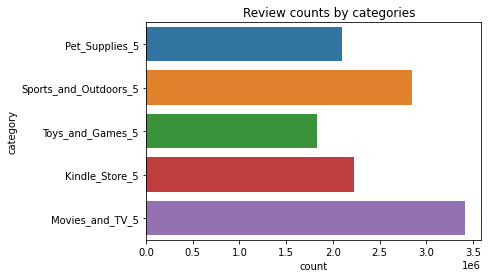

In [37]:
sns.countplot(data=result, y="category")
plt.title("        Review counts by categories")
# plt.yticks(rotation=45)

Text(0, 0.5, 'Number of Reviews')

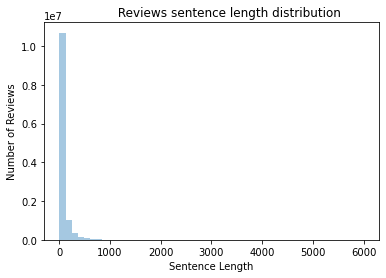

In [39]:
sns.distplot(a=result["sentenceLength"], kde=False)
plt.title("         Reviews sentence length distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Reviews")

Text(0, 0.5, 'Number of Reviews')

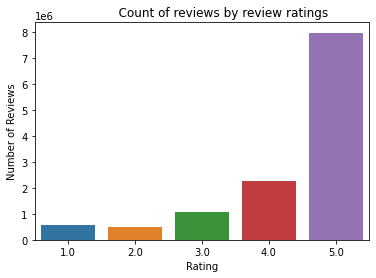

In [35]:
sns.countplot(x=result["overall"])
plt.title("           Count of reviews by review ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")

In [13]:
lt2000 = result[result["sentenceLength"]<=2000]

Text(0, 0.5, 'Number of Reviews')

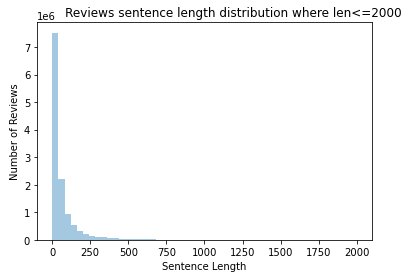

In [33]:
sns.distplot(a=lt2000["sentenceLength"], kde=False)
plt.title("               Reviews sentence length distribution where len<=2000")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Reviews")

Text(0.5, 1.0, '      Ratings v/s Sentence Length')

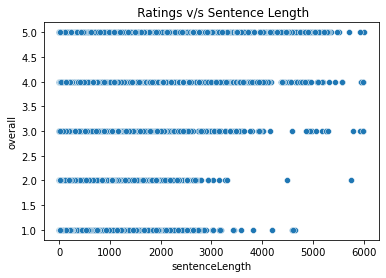

In [36]:
sns.scatterplot(x=result['sentenceLength'], y=result['overall'])
plt.title("      Ratings v/s Sentence Length")

In [16]:
gt2000 = result[result["sentenceLength"]>2000]

In [17]:
gt2000.shape

(1930, 4)

In [18]:
gt2000.sample(n=10)

,reviewText,overall,sentenceLength,category
2021934,--SPOILERS--\n\nLiked it more than I expected ...,2.0,2115,Movies_and_TV_5
2190816,NON-SPOILER REVIEW (mostly) OF CAPTAIN AMERICA...,5.0,2620,Movies_and_TV_5
1071257,Any meditation on early 1970's child pop cultu...,4.0,2674,Movies_and_TV_5
1840448,Conan the Barbarian as a film is about as subt...,5.0,2245,Movies_and_TV_5
1846264,(This review is about both the Theatrical and ...,4.0,2183,Movies_and_TV_5
2849888,He's one of the rare men in this business who ...,4.0,2988,Movies_and_TV_5
689898,The following is pretty much the review that I...,5.0,2049,Movies_and_TV_5
759366,It was hard to rate this documentary in terms ...,3.0,2485,Movies_and_TV_5
1151521,NOTE: I UPDATED THIS REVIEW IN 2015\n\nIn a sp...,5.0,3828,Movies_and_TV_5
3225286,NOTE: these reviews of six films of Eric Rohme...,5.0,3487,Movies_and_TV_5


In [19]:
gt350 = result[result["sentenceLength"]>350]

In [20]:
gt350.shape

(344577, 4)

In [21]:
result.shape

(12400238, 4)

#### Insights from analysis

1. From sentence length distribution graphs we can see distribution is a bit skewed and becomes a long tail after sentence length gte 350. In fact gt2000 is only ~2.5% of overall reviews.  
2. Review rating doesn't seem to have any correlation with sentence length as can be seen from scatterplot; every rating has majority of all length reviews. So, no need to add rating as a pivot.
3. So, a simple stratified sampling to generate sentence initial seeds can follow below strategy:  
   3.1. Consider top-10 categories that we have been considering.  
   3.2. Iterate category by category and,  
   3.3. From sample of sentences having sentence length <= 350 we can safely sample "n" sentences and let the sample follow original distribution. Take initials from these sentences and generate different length texts.  
   3.4. From sample of sentences having sentence length > 350 maybe we can sample "2n" or "3n" sentences to balance our dataset for subsequent classification problem. Take initials from these sentences and generate different length texts.  